# Lecture 16: Karger's algorithm

In [1]:
from graphStuff import *
from random import choice
from random import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Here's Karger's algorithm

It's not a very savvy implementation, but it's good enough for us

In [2]:
def karger(G):
    superG = CS161Graph()
    for v in G.vertices:
        N = CS161Vertex([v])
        v.superNode = N
        superG.addVertex( N )
    # superG starts out as the complete graph; this isn't a smart implementation choice for sparse graphs
    for i in range(len(G.vertices)):
        for j in range(i+1, len(G.vertices)):
            u = G.vertices[i]
            v = G.vertices[j]
            E = u.getEdge(v)
            if E == None:
                val = []
            else:
                val = [E]
            U = u.superNode
            V = v.superNode
            superG.addEdge(U,V,val=val)

    currentEdges = G.getEdges()
    while len(superG.vertices) > 2:
        E = choice(currentEdges)
        u,v = E.endpts

        U = u.superNode
        V = v.superNode
        UV = U.getEdge(V)
        for e in UV.value:
            if e in currentEdges:
                currentEdges.remove(e)
        merge(E,superG)
    return superG.vertices[0].value, superG.vertices[1].value, superG.vertices[0].getEdge(superG.vertices[1]).value

# merge the endpoints of E (which is an edge in G) in the super-graph superG
def merge(E,superG):
    u,v = E.endpts
    U = u.superNode
    V = v.superNode
    X = CS161Vertex(U.value + V.value)  # merge the super-vertices
    for x in V.value:
        x.superNode = X
    for y in U.value:
        y.superNode = X
    for W in superG.vertices:
        if W == U or W == V:
            continue
        WU = U.getEdge(W)
        WV = V.getEdge(W)
        XWval = WU.value + WV.value # concatenate the two super-edges
        superG.addEdge(X,W,XWval)
    superG.removeVertex(U)
    superG.removeVertex(V)
    superG.addVertex(X)

### Does it work?  Let's try it with the graph from the slides.

In [3]:
# Here's the graph from the slides:
n = 8
G = CS161Graph()
for i in range(n):
    v = CS161Vertex(i)
    G.addVertex(v)
for i,j in [(1,3), (1,2), (1,4), (2,3), (2,4), (3,4), (2,5),(4,5), (5,6), (5,7),(5,0), (6,7),(6,0), (7,0)]:
    G.addEdge(G.vertices[i], G.vertices[j])


In [4]:
# Just to see what it does:
A,B,E = karger(G)
print([ str(x) for x in A ])
print([str(x) for x in B])
print([str(e) for e in E])

['1']
['3', '2', '4', '5', '6', '0', '7']
['1,3:None', '1,2:None', '1,4:None']


In [5]:
# Now let's try it a bunch of times
T = 10000
data = [0 for i in range(len(G.getEdges()))]
for t in range(T):
    A,B,E = karger(G)
    cutSize = len(E)
    data[cutSize] += 1
for i in range(len(data)):
    data[i] = data[i]/T

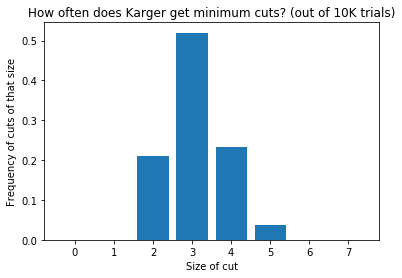

In [6]:
plt.bar(range(8),data[:8])
plt.title("How often does Karger get minimum cuts? (out of 10K trials)")
plt.xlabel('Size of cut')
plt.ylabel('Frequency of cuts of that size')
plt.show()

### Yikes! 

Looks like it's only correct about 20% of the time. 

But is that good or bad?  For example, what if we just choose completely random cuts?

In [7]:
# This function chooses a random cut and returns the size of that cut
def sizeofRandomCut(G):
    A = []
    for v in G.vertices:
        if random() < 0.5:
            A.append(v)
    if len(A) == 0 or len(A) == len(G.vertices):
        return None
    edges = []
    for v in A:
        for E in v.neighbors:
            if E.endpts[0] not in A or E.endpts[1] not in A:
                if E not in edges:
                    edges.append(E)
    return len(edges)

In [8]:
# Now let's try it a bunch of times
T = 10000
dataRandom = [0 for i in range(len(G.getEdges()))]
for t in range(T):
    cutSize = None
    while cutSize == None:
        cutSize = sizeofRandomCut(G)
    dataRandom[cutSize] += 1
for i in range(len(data)):
    dataRandom[i] = dataRandom[i]/T

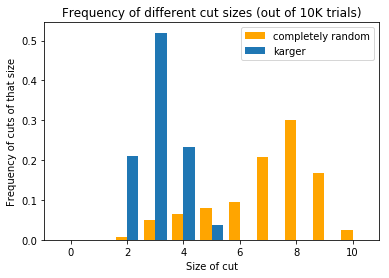

In [9]:
plt.bar([ x - 0.2 for x in range(11)],dataRandom[:11],color="orange",width=0.4,label="completely random")
plt.bar([ x + 0.2 for x in range(11)],data[:11],width=0.4, label="karger")
plt.title("Frequency of different cut sizes (out of 10K trials)")
plt.xlabel('Size of cut')
plt.ylabel('Frequency of cuts of that size')
plt.legend()
plt.show()

### Okay, so now our final algorithm will be to run Kruskal a bunch -- how well does this work?

In [11]:
def findAMinCut(G,T):
    bestCut = None
    bestSize = np.inf
    for t in range(T):
        A,B,E = karger(G)
        cutSize = len(E)
        if cutSize < bestSize:
            bestSize = cutSize
            bestCut = A,B,E
    return bestCut

In [12]:
Tmax = 30
nTrials = 100
repeatData = [0 for i in range(Tmax)]
for T in range(1, Tmax):
    for t in range(nTrials):
        A,B,E = findAMinCut(G,T)
        if len(E) == 2:
            repeatData[T] += 1
    repeatData[T] /= nTrials    

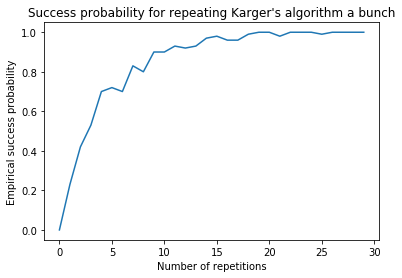

In [13]:
plt.plot( repeatData )
plt.title( "Success probability for repeating Karger's algorithm a bunch" )
plt.xlabel( "Number of repetitions" )
plt.ylabel( "Empirical success probability")
plt.show()

Looks like it gets real good real fast!  Hooray!